In [48]:
import pandas as pd
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# Getting file directory
base_dir = os.getcwd()

# Getting csv's
tnst = pd.read_csv(base_dir+"\\tnst_dt.csv")
metar = pd.read_csv(base_dir+"\\metar_dt.csv")

# Convert date columns to datetime
tnst["date"] = pd.to_datetime(tnst["date"], utc=True)
metar["date"] = pd.to_datetime(metar["date"], utc=True)

# Sort both by date (required for merge_asof)
tnst = tnst.sort_values("date")
metar = metar.sort_values("date")

# Renaming metar date
metar = metar.rename(columns={"date": "metar_date"})

# Merge METAR features into TNST by closest previous METAR time
# 'direction="nearest"' uses the nearest time (can also use 'backward' or 'forward')
merged_data = pd.merge_asof(
    tnst,
    metar,
    left_on="date",
    right_on="metar_date",
    direction="backward"  # can also specify tolerance=pd.Timedelta("1h") if needed
)

# Showing results
print(merged_data.head())

                       date  icao  weather_delay  congestion_score  yes_delay  \
0 2013-01-01 12:00:00+00:00  KBNA            0.0         10.000000      False   
1 2013-01-01 12:00:00+00:00  KBNA            0.0         10.000000      False   
2 2013-01-01 12:05:00+00:00  KBNA            0.0          6.333333      False   
3 2013-01-01 12:20:00+00:00  KBNA            0.0          6.666667      False   
4 2013-01-01 12:30:00+00:00  KBNA            0.0         10.000000      False   

   delay_bin                metar_date  wind_dir  wind_speed  ceiling  \
0          0 2013-01-01 09:53:00+00:00       170          21      335   
1          0 2013-01-01 09:53:00+00:00       170          21      335   
2          0 2013-01-01 09:53:00+00:00       170          21      335   
3          0 2013-01-01 09:53:00+00:00       170          21      335   
4          0 2013-01-01 09:53:00+00:00       170          21      335   

   visibility  temp  dew_pnt  pressure  
0        4828    50       39     

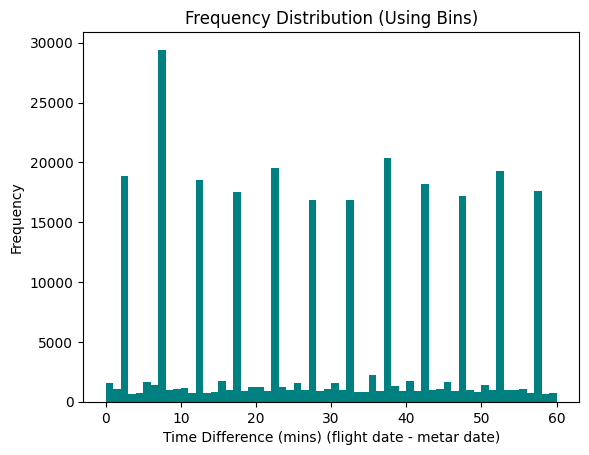

Bin Edges:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60.]
Frequencies:
 [ 1542.  1066. 18851.   654.   725.  1607.  1439. 29412.   971.  1027.
  1157.   745. 18527.   768.   772.  1712.   973. 17516.   937.  1210.
  1230.   876. 19559.  1199.   997.  1584.   953. 16865.   865.  1103.
  1606.   999. 16871.   818.   813.  2217.   909. 20371.  1291.   907.
  1690.   935. 18169.  1017.  1026.  1681.   855. 17179.  1004.   831.
  1387.   997. 19305.   946.  1021.  1091.   754. 17583.   611.   758.]
Index(['date', 'icao', 'weather_delay', 'congestion_score', 'yes_delay',
       'delay_bin', 'metar_date', 'wind_dir', 'wind_speed', 'ceiling',
       'visibility', 'temp', 'dew_pnt', 'pressure', 'time_diff',
       'time_of_day'],
      dtype='object')
                       date  icao  weather_d

In [49]:
# -------------------------------------------------
# ADDING TIME DIFFERENCE (flight date - metar date) COLUMN
# AND ADDING HOUR COLUMN
# -------------------------------------------------

# Adding difference
merged_data["time_diff"] = (merged_data["date"]-merged_data["metar_date"]).dt.total_seconds() // 60

# Showing results
custom_bins = np.arange(0, 61, 1) # Results greater than an hour will be ignored
counts, bin_edges, patches = plt.hist(merged_data["time_diff"], bins=custom_bins, color="teal")
plt.xlabel("Time Difference (mins) (flight date - metar date)")
plt.ylabel("Frequency")
plt.title("Frequency Distribution (Using Bins)")
plt.show()
print("Bin Edges:\n", bin_edges)
print("Frequencies:\n", counts)

# Adding flight time of day scheduled time (in mins)
merged_data["time_of_day"] = (merged_data["date"].dt.hour * 60 +
                        merged_data["date"].dt.minute +
                        merged_data["date"].dt.second // 60
                        )

# Showing results
print(merged_data.columns)
print(merged_data.head())

# Saving data
merged_data.to_csv("merged_data.csv")

           congestion_score  wind_dir  wind_speed   ceiling  visibility  \
time_diff                                                                 
0                 -0.072958 -0.034279   -0.014859 -0.078450   -0.104157   
1                 -0.027753  0.001585    0.010465 -0.023448   -0.057360   
2                 -0.026101  0.014265    0.035594 -0.043913   -0.057642   
3                 -0.054421  0.035831   -0.050028 -0.030297    0.010131   
4                 -0.008327 -0.030146   -0.022999  0.027512    0.033798   

               temp   dew_pnt  pressure  time_of_day  
time_diff                                             
0         -0.097953 -0.074029  0.027659    -0.045460  
1         -0.022371 -0.008254 -0.037109     0.043560  
2          0.010414  0.025232 -0.037527     0.036806  
3          0.027395  0.090717 -0.064265     0.088870  
4          0.048573  0.036303 -0.040223     0.098307  


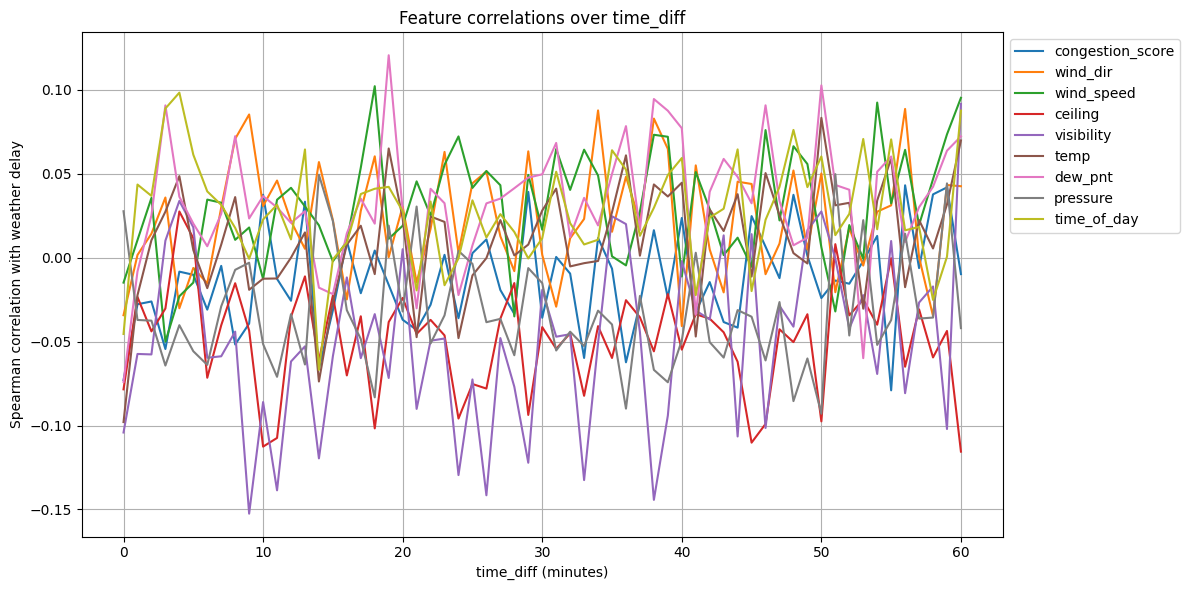

In [ ]:
# -------------------------------------------------
# Evaluating Valid Time Difference
# (when does time difference get too long)

# THIS DID NOT WORK - BECAUSE FEATURES DON'T HAVE A CLEAR
# MONOTONIC CORRELATIONS IT MEANS THAT ATTEMPTING TO ANALYZE
# HOW THAT CORRELATION VARIES WITH TIME DIFFERENCE IS INEFFECTIVE
# -------------------------------------------------

# Copying data
data_copy = merged_data.copy(deep=True)

# Dopping non-features & splitting into time_diff blocks
feature_data = data_copy.drop(columns=["date", "icao", "yes_delay", 
                                       "yes_delay", "delay_bin", "metar_date"]) # We'll remove time_diff, and delay_bins later

corrs = [] # correlations for each time_diff
for i in range(0, 61): # looking at max 1 hour
    feature_data_i = feature_data.loc[feature_data["time_diff"] == i].copy(deep=True)
    feature_data_i_ = feature_data_i.drop(columns=["time_diff", "weather_delay"])
    corr_i = feature_data_i_.corrwith(feature_data_i["weather_delay"], method="spearman")
    corrs.append(corr_i)

# Converting corrs list to dataframe each row corresponds to correlations for a time_diff
corrs_df = pd.DataFrame(corrs)
corrs_df.index.name = "time_diff" # naming index
print(corrs_df.head())

# Showing correlations of features vs time_diff
plt.figure(figsize=(12,6))
for feature in corrs_df.columns:
    plt.plot(corrs_df.index, corrs_df[feature], label=feature)
plt.xlabel("time_diff (minutes)")
plt.ylabel("Spearman correlation with weather delay")
plt.title("Feature correlations over time_diff")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')  # Put legend outside
plt.grid(True)
plt.tight_layout()
plt.show()